In [32]:
# https://medium.com/@krishnusai/mastering-natural-language-processing-with-spacy-a-comprehensive-guide-5e67ce30d6ab
# https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/

In [48]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/forum-discustion/sample_submission.csv
/kaggle/input/forum-discustion/ClassesMap.txt
/kaggle/input/forum-discustion/train.csv
/kaggle/input/forum-discustion/test.csv


In [49]:
import re
import emoji
import spacy
import numpy as np
import pandas as pd
from nltk import ngrams
from nltk.corpus import words
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from urllib.parse import urlparse
# from wordsegment import load,segment
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
dataset_path = '/kaggle/input/forum-discustion'
train = pd.read_csv(dataset_path + '/train.csv')
print("All train Data Shape:",train.shape)

All train Data Shape: (24989, 3)


# Preprocessing

## Nulls

In [51]:
sum(train['Discussion'].isna())

343

In [52]:
train.dropna(inplace=True)
# replace with dummy string
# train['Discussion'] = train.apply(lambda row: f"Generated text for category {row['Category']}" if pd.isnull(row['Discussion']) or row['Discussion'].strip() == '' else row['Discussion'], axis=1)
print("All train Data Shape:",train.shape)

All train Data Shape: (24646, 3)


## Split Data

In [53]:
print("unique values: ",train['Category'].unique())
print("number of  STEM: ",(train['Category'] == 'STEM').sum())
print("number of  Media: ",(train['Category'] == 'Media').sum())
print("number of  Sports: ",(train['Category'] == 'Sports').sum())
print("number of  Politics: ",(train['Category'] == 'Politics').sum())
print("number of  Market & Economy: ",(train['Category'] == 'Market & Economy').sum())

unique values:  ['Sports' 'STEM' 'Politics' 'Media' 'Market & Economy']
number of  STEM:  5351
number of  Media:  4141
number of  Sports:  5526
number of  Politics:  4156
number of  Market & Economy:  5472


In [54]:
X = train['Discussion'].astype(str)
y = train['Category']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
print("X_train Shape:",X_train.shape)
print("y_train Shape:",y_train.shape)
print("X_test Shape:",X_valid.shape)

X_train Shape: (19716,)
y_train Shape: (19716,)
X_test Shape: (4930,)


In [55]:
print("unique values: ",y_train.unique())
print("number of  STEM: ",(y_train == 'STEM').sum())
print("number of  Media: ",(y_train == 'Media').sum())
print("number of  Sports: ",(y_train == 'Sports').sum())
print("number of  Politics: ",(y_train == 'Politics').sum())
print("number of  Market & Economy: ",(y_train == 'Market & Economy').sum())
print()
print("number of  STEM: ",(y_valid == 'STEM').sum())
print("number of  Media: ",(y_valid == 'Media').sum())
print("number of  Sports: ",(y_valid == 'Sports').sum())
print("number of  Politics: ",(y_valid == 'Politics').sum())
print("number of  Market & Economy: ",(y_valid == 'Market & Economy').sum())
print()

unique values:  ['Media' 'STEM' 'Sports' 'Market & Economy' 'Politics']
number of  STEM:  4281
number of  Media:  3313
number of  Sports:  4420
number of  Politics:  3325
number of  Market & Economy:  4377

number of  STEM:  1070
number of  Media:  828
number of  Sports:  1106
number of  Politics:  831
number of  Market & Economy:  1095




## Cleaning Text

I don't care about punct, links, numbers. as my task is classification of text

URL
- put domain and path as place holder

## Tokenization
Techniques:
- Word Tokenizer
- wordpunct_tokenize
- TreebankWordTokenizerbreak down text into words, punctuation, and other elements
- N-gram (Handling Ambiguity)

I will use ***Word Tokenizer,N-gram***. as i don't care about punctuatoins i don't care about# Vectorization
-

In [56]:
def extract_url_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path
    query = parsed_url.query
    tld = domain.split('.')[-1]
    domain = re.sub(r'\bwww\b', '', domain)
    domain = re.sub(r'\.com\b', '', domain)
    return  domain+' '+path

def place_holder_url(text):
    urls = re.findall(r'https?://(?:www\.)?[^\s/$.?#].[^\s]*', text)
    for url in urls:
        text = text.replace(url, extract_url_features(url))
    return text

def remove_urls(text):
    return re.sub(r'https?://(?:www\.)?[^\s/$.?#].[^\s]*', '', text)

import spacy
nlp = spacy.load('en_core_web_sm')
def remove_non_nouns_verbs(text):
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'VERB','PROPN']]
    return ' '.join(filtered_words)

def delete_emoji(text):
    # Emoji pattern
    emoji_pattern = re.compile(
        r"[\U0001F600-\U0001F64F"  # Emoticons
        r"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        r"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        r"\U0001F700-\U0001F77F"  # Alchemical Symbols
        r"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        r"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        r"\U0001F900-\U0001F9FF"  # Supplemental Symbols & Pictographs
        r"\U0001FA00-\U0001FA6F"  # Chess Symbols
        r"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        r"\U00002702-\U000027B0"  # Dingbats
        r"\U000024C2-\U0001F251"  # Enclosed Characters
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(" ", text)

   
def clean_text(text):
    text = text.lower()
    text = re.sub(r'(.)\1{2,}', r'\1\1', text) # ahhhhh -> ah
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) 
    text = delete_emoji(text)
    text = remove_non_nouns_verbs(text)
    text = re.sub(r'\s+', ' ', text) 
    return text

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [57]:
#Run in 3 min
cleaned_X_train = X_train.apply(place_holder_url).apply(clean_text)
print("shape",cleaned_X_train.shape)
cleaned_X_train.head(1)

shape (19716,)


4590    jake gyllenhal
Name: Discussion, dtype: object

In [58]:
#Run in 2 min
cleaned_X_valid = X_valid.apply(place_holder_url).apply(clean_text)
print("shape",cleaned_X_valid.shape)
cleaned_X_valid.head(1)

shape (4930,)


5309    rag thing work co welding supply store part ha...
Name: Discussion, dtype: object

In [59]:
cleaned_X_train

4590                                        jake gyllenhal
7599     check ip address client machine use command st...
6733                 have do make contact ball bat get hit
7726                                  detroit piston score
10214    like poke fun poke fun people think poke fun c...
                               ...                        
21565                                      kansas jayhawks
15491    like think bracket have tweak follow conferenc...
21604    list dvds work burner operator manual ntdk sup...
9411                                            hand state
14072    decide take t care don t provide sideline chee...
Name: Discussion, Length: 19716, dtype: object

## Encoding Y

In [60]:
def encode_labels(labels):
  manual_mapping = {
      'Politics': 0,
      'Sports': 1,
      'Media': 2,
      'Market & Economy': 3,
      'STEM': 4
  }
  encoded_labels = [manual_mapping[label] for label in labels]
  return encoded_labels

y_train = encode_labels(y_train)
y_valid = encode_labels(y_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
print("Ensure Enconded y_train: ",y_train[0:2])

Ensure Enconded y_train:  [2 4]


# Vectorization 

In [61]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english',min_df=2)
with_urls_X_vectorized = vectorizer.fit_transform(cleaned_X_train)
with_urls_X_valid_vectorized = vectorizer.transform(cleaned_X_valid)

X_train_tfidf  =pd.DataFrame(
     with_urls_X_vectorized.todense(),
     columns = vectorizer.get_feature_names_out()
)

X_valid_tfidf  = pd.DataFrame(
     with_urls_X_valid_vectorized.todense(),
     columns = vectorizer.get_feature_names_out()
)

In [62]:
np.unique(X_train_tfidf)

array([0.        , 0.00288046, 0.00300412, ..., 0.98228392, 0.98401511,
       1.        ])

In [63]:
print("X_train_tfidf Shape:",X_train_tfidf.shape)
print("y_train Shape:",len(y_train))
print("X_valid_tfidf Shape:",X_valid_tfidf.shape)
print("y_train Shape:",len(y_valid))
print("X_train_tfidf columns ",len(X_train_tfidf.columns))
print("X_valid_tfidf columns ",len(X_valid_tfidf.columns))

X_train_tfidf Shape: (19716, 10000)
y_train Shape: 19716
X_valid_tfidf Shape: (4930, 10000)
y_train Shape: 4930
X_train_tfidf columns  10000
X_valid_tfidf columns  10000


# Embedding

# Embedding
Word2vec
- Creates dense vector representations (embeddings)
- Captures semantic relationships between words
- Words with similar meanings have similar vectors
- Learns from context and word relationships



## W2V

In [64]:
import numpy as np 
np.mean([[1,2,3],[1,1,1],[1,1,1]],axis=0)

array([1.        , 1.33333333, 1.66666667])

In [65]:
# !pip install gensim

In [67]:
from gensim.models import Word2Vec
import gensim

vector_size = 100
tokenized_X_train = [text.split() for text in cleaned_X_train]
tokenized_X_valid = [text.split() for text in cleaned_X_valid]
cbow_w2v = gensim.models.Word2Vec(
    sentences=tokenized_X_train,
    min_count=2,
    vector_size=vector_size, 
    window=5,
    workers=8
)
 
def text_to_vectors(tokenized_texts):
    doc_vectors = []
    for text in tokenized_texts:
        word_vectors = [cbow_w2v.wv[word] for word in text if word in cbow_w2v.wv]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            doc_vector = np.zeros(vector_size)  
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)

X_train_w2v = text_to_vectors(tokenized_X_train)
X_valid_w2v = text_to_vectors(tokenized_X_valid)

# Modeling

In [68]:
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization,Conv1D,MaxPooling1D,Flatten

clean X_test

In [23]:
def clean_x_validortest(X_test):
    return X_test.apply(place_holder_url).apply(clean_text)

prepare X_test

In [24]:
test = pd.read_csv(dataset_path + '/test.csv')
print("Shape X_test",test.shape)
X_test = clean_x_validortest(test['Discussion'])

Shape X_test (10557, 2)


vectorization X_test

In [25]:
X_test_vectorized = vectorizer.transform(X_test)
X_test_tfidf  = pd.DataFrame(
     X_test_vectorized.todense(),
     columns = vectorizer.get_feature_names_out()
)
print("Shape X_test",X_test_tfidf.shape)

Shape X_test (10557, 10000)


Embedding X_test

w2v

In [26]:
tokenized_X_test = [text.split() for text in X_test]
X_test_w2v = text_to_vectors(tokenized_X_test)

## Neural Network

### tfidf

In [69]:
dense_model = Sequential()

dense_model.add(Input(shape=(X_train_tfidf.shape[1],)))

dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(64, activation='relu'))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(5, activation='softmax'))  
dense_model.compile(optimizer=Adamax(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,709 (4.92 MB)

 Trainable params: 1,288,709 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-5, patience=2, verbose=1)
h1 = dense_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_valid_tfidf,y_valid),
    epochs=50, 
    batch_size=16,
    callbacks=[early_stopping,reduce_lr]
)

train_loss, train_accuracy = dense_model.evaluate(X_train_tfidf, y_train)
valid_loss, valid_accuracy = dense_model.evaluate(X_valid_tfidf, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4328 - loss: 1.3533 - val_accuracy: 0.6436 - val_loss: 0.9575 - learning_rate: 0.1000
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6242 - loss: 0.9922 - val_accuracy: 0.6716 - val_loss: 0.9172 - learning_rate: 0.1000
Epoch 3/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6736 - loss: 0.8755 - val_accuracy: 0.6799 - val_loss: 0.8866 - learning_rate: 0.1000
Epoch 4/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6983 - loss: 0.8078 - val_accuracy: 0.6809 - val_loss: 0.9325 - learning_rate: 0.1000
Epoch 5/50
1222/1233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7193 - loss: 0.7633
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7193 - loss: 0.7633 - val_accuracy: 0.6809 - val_loss: 0.9457 - learning_rate: 0.1000
Epoch 6/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7509 - los

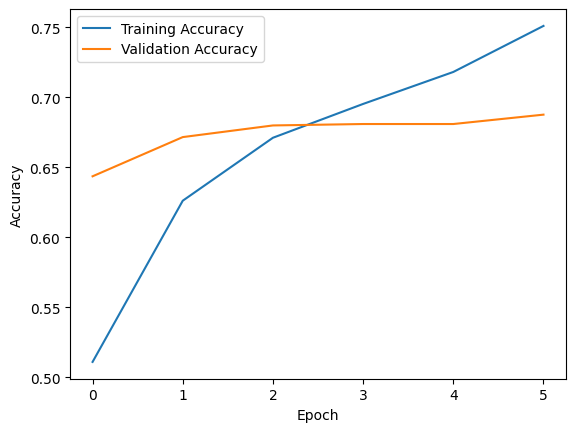

In [71]:
import matplotlib.pyplot as plt
plt.plot(h1.history['accuracy'], label='Training Accuracy')
plt.plot(h1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# dense_model.save("dense_model.keras")

In [78]:
dense_model = Sequential()

dense_model.add(Input(shape=(X_train_tfidf.shape[1],)))

dense_model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.008)))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.008)))
dense_model.add(Dropout(0.5))

dense_model.add(Dense(5, activation='softmax'))  

dense_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,709 (4.92 MB)

 Trainable params: 1,288,709 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-6, patience=2, verbose=1)

h2 = dense_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_valid_tfidf,y_valid),
    epochs=50, 
    batch_size=16,
    callbacks=[early_stopping,reduce_lr],
)

train_loss, train_accuracy = dense_model.evaluate(X_train_tfidf, y_train)
valid_loss, valid_accuracy = dense_model.evaluate(X_valid_tfidf, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2635 - loss: 1.8333 - val_accuracy: 0.4223 - val_loss: 1.5710 - learning_rate: 0.0010
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4034 - loss: 1.5512 - val_accuracy: 0.4609 - val_loss: 1.4654 - learning_rate: 0.0010
Epoch 3/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4492 - loss: 1.4637 - val_accuracy: 0.4992 - val_loss: 1.4082 - learning_rate: 0.0010
Epoch 4/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4799 - loss: 1.4194 - val_accuracy: 0.5412 - val_loss: 1.3608 - learning_rate: 0.0010
Epoch 5/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5101 - loss: 1.3743 - val_accuracy: 0.5639 - val_loss: 1.3267 - learning_rate: 0.0010
Epoch 6/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5356 - loss: 1.3437 - val_accuracy: 0.5901 - val_loss: 1.2976 - learning_rate: 0.0010
Epoch 7/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5616 - l

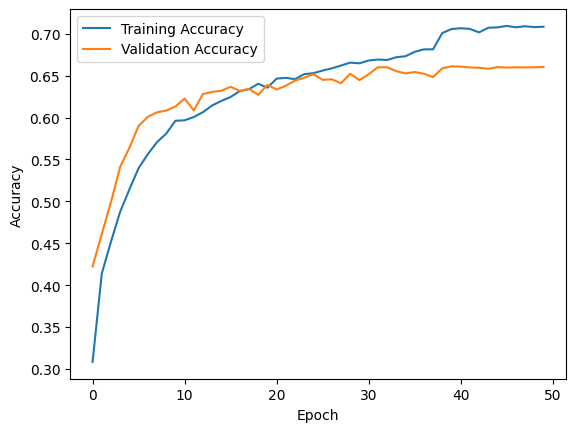

In [74]:
import matplotlib.pyplot as plt
plt.plot(h2.history['accuracy'], label='Training Accuracy')
plt.plot(h2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [75]:
dense_model = Sequential()

dense_model.add(Input(shape=(X_train_tfidf.shape[1],)))
dense_model.add(Dense(128, activation='relu',kernel_initializer=HeNormal(seed=42) ,kernel_regularizer=l2(0.001)))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(64, activation='relu',kernel_initializer=HeNormal(seed=42),kernel_regularizer=l2(0.001)))
dense_model.add(Dense(5, activation='softmax'))  #
dense_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,709 (4.92 MB)

 Trainable params: 1,288,709 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

h3 = dense_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_valid_tfidf,y_valid),
    epochs=50, 
    batch_size=16,
    callbacks=[early_stopping]
)

train_loss, train_accuracy = dense_model.evaluate(X_train_tfidf, y_train)
valid_loss, valid_accuracy = dense_model.evaluate(X_valid_tfidf, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4000 - loss: 1.5867 - val_accuracy: 0.6193 - val_loss: 1.1515
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6325 - loss: 1.1150 - val_accuracy: 0.6702 - val_loss: 1.0305
Epoch 3/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6918 - loss: 0.9893 - val_accuracy: 0.6901 - val_loss: 0.9753
Epoch 4/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7219 - loss: 0.9122 - val_accuracy: 0.6929 - val_loss: 0.9580
Epoch 5/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7431 - loss: 0.8575 - val_accuracy: 0.6963 - val_loss: 0.9457
Epoch 6/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7590 - loss: 0.8311 - val_accuracy: 0.6990 - val_loss: 0.9414
Epoch 7/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7719 - loss: 0.7939 - val_accuracy: 0.7006 - val_loss: 0.9421
Epoch 8/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7797 - loss: 0.7673 - 

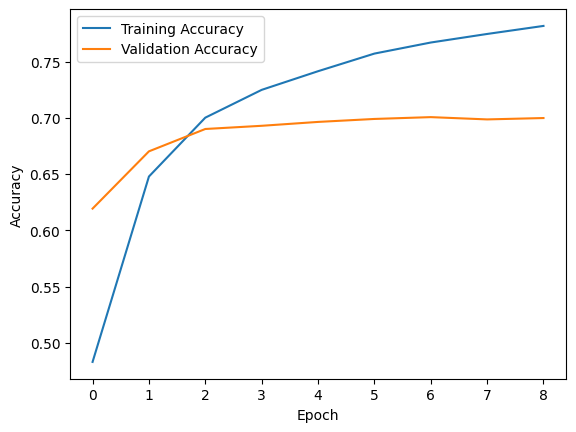

In [77]:
import matplotlib.pyplot as plt

plt.plot(h3.history['accuracy'], label='Training Accuracy')
plt.plot(h3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score
# y_pred = np.argmax(dense_model.predict(X_train_tfidf), axis=1)  
# cm = confusion_matrix(y_train, y_pred)
# macro_precision = precision_score(y_train, y_pred, average='macro')
# macro_recall = recall_score(y_train, y_pred, average='macro')
# print("Macro Precision:", macro_precision)
# print("Macro Recall:", macro_recall)

In [ ]:
# predictions = dense_model.predict(X_test_tfidf)
# predicted_classes = np.argmax(predictions, axis=1)
# predicted_classes

In [ ]:
# df_predictions = pd.DataFrame({
#     'SampleID': test['SampleID'],
#     'Predicted_Class': predicted_classes
# })

# df_predictions.to_csv('dense_predictions.csv', index=False)

# print(df_predictions)

### modelling with w2v

In [79]:
X_train_w2v.shape

(19716, 100)

In [80]:
dense_model = Sequential()

dense_model.add(Input(shape=(X_train_w2v.shape[1],)))
dense_model.add(Dense(128, activation='relu',kernel_initializer=HeNormal(seed=42) ,kernel_regularizer=l2(0.001)))
dense_model.add(Dropout(0.5))
dense_model.add(Dense(64, activation='relu',kernel_initializer=HeNormal(seed=42),kernel_regularizer=l2(0.001)))

dense_model.add(Dense(5, activation='softmax'))  

dense_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

dense_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,509 (84.02 KB)

 Trainable params: 21,509 (84.02 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

h4 = dense_model.fit(
    X_train_w2v, y_train,
    validation_data=(X_valid_w2v,y_valid),
    epochs=50, 
    batch_size=16,
    callbacks=[early_stopping] 
)

train_loss, train_accuracy = dense_model.evaluate(X_train_w2v, y_train)
valid_loss, valid_accuracy = dense_model.evaluate(X_valid_w2v, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4529 - loss: 1.6862 - val_accuracy: 0.5722 - val_loss: 1.4102
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5561 - loss: 1.4316 - val_accuracy: 0.5787 - val_loss: 1.3441
Epoch 3/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5630 - loss: 1.3794 - val_accuracy: 0.5897 - val_loss: 1.3034
Epoch 4/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5737 - loss: 1.3325 - val_accuracy: 0.5870 - val_loss: 1.2721
Epoch 5/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5849 - loss: 1.2794 - val_accuracy: 0.5915 - val_loss: 1.2461
Epoch 6/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5851 - loss: 1.2637 - val_accuracy: 0.5966 - val_loss: 1.2270
Epoch 7/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5846 - loss: 1.2530 - val_accuracy: 0.5945 - val_loss: 1.2077
Epoch 8/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5762 - loss: 1.2403 - 

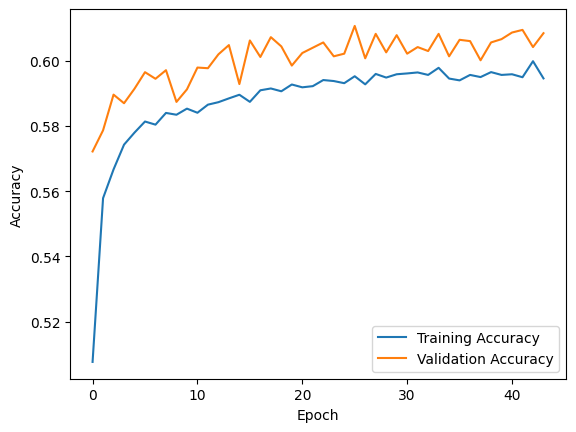

In [82]:
import matplotlib.pyplot as plt
plt.plot(h4.history['accuracy'], label='Training Accuracy')
plt.plot(h4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN

In [84]:
from tensorflow.keras.regularizers import l2

cnn_model = Sequential()

cnn_model.add(Input(shape=(X_train_tfidf.shape[1], 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(5, activation='softmax'))

cnn_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 9998, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4999, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4999, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4997, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2498, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2498, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 319744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │      40,927,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,977,797 (156.32 MB)

 Trainable params: 40,977,797 (156.32 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

h1= cnn_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_valid_tfidf,y_valid),
    epochs=50, 
    batch_size=128,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weights_dict,
)

train_loss, train_accuracy = cnn_model.evaluate(X_train_tfidf, y_train)
valid_loss, valid_accuracy = cnn_model.evaluate(X_valid_tfidf, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")
# Final:  Train Loss: 0.9530853033065796, Train Accuracy: 0.7973726987838745
# Final:  Validation Loss: 1.2023688554763794, Validation Accuracy: 0.6693711876869202

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - accuracy: 0.4245 - loss: 2.3560 - val_accuracy: 0.6201 - val_loss: 1.4663 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.6220 - loss: 1.4643 - val_accuracy: 0.6241 - val_loss: 1.3902 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.6502 - loss: 1.3594 - val_accuracy: 0.6465 - val_loss: 1.3475 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.6580 - loss: 1.3189 - val_accuracy: 0.6432 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.6680 - loss: 1.2820 - val_accuracy: 0.6495 - val_loss: 1.2894 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.6838 - loss: 1.2425 - val_accuracy: 0.6458 - val_loss: 1.2807 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.6

In [86]:
from tensorflow.keras.regularizers import l2

cnn_model = Sequential()

cnn_model.add(Input(shape=(X_train_tfidf.shape[1], 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(5, activation='softmax'))

cnn_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 4996, 256)           │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2498, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 2498, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 639488)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │      81,854,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,954,565 (312.63 MB)

 Trainable params: 81,954,565 (312.63 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

h2= cnn_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_valid_tfidf,y_valid),
    epochs=50, 
    batch_size=128,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weights_dict,
)

train_loss, train_accuracy = cnn_model.evaluate(X_train_tfidf, y_train)
valid_loss, valid_accuracy = cnn_model.evaluate(X_valid_tfidf, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")
# Final:  Train Loss: 1.021488070487976, Train Accuracy: 0.7516230344772339
# Final:  Validation Loss: 1.2056119441986084, Validation Accuracy: 0.653346836566925

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step - accuracy: 0.2859 - loss: 2.5248 - val_accuracy: 0.5649 - val_loss: 1.5714 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.5711 - loss: 1.5865 - val_accuracy: 0.5878 - val_loss: 1.4849 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.6036 - loss: 1.4799 - val_accuracy: 0.6132 - val_loss: 1.4214 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.6202 - loss: 1.4216 - val_accuracy: 0.6207 - val_loss: 1.3884 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.6275 - loss: 1.3814 - val_accuracy: 0.6308 - val_loss: 1.3393 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.6439 - loss: 1.3294 - val_accuracy: 0.6337 - val_loss: 1.3137 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.6

In [88]:
from tensorflow.keras.regularizers import l2

cnn_model = Sequential()

cnn_model.add(Input(shape=(X_train_tfidf.shape[1], 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(5, activation='softmax'))

cnn_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 9998, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 4999, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 4999, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 4997, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 2498, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2498, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 319744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │      40,927,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,977,797 (156.32 MB)

 Trainable params: 40,977,797 (156.32 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

h3= cnn_model.fit(
    X_train_tfidf, y_train,
    validation_data=(X_valid_tfidf,y_valid),
    epochs=50, 
    batch_size=128,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weights_dict,
)

train_loss, train_accuracy = cnn_model.evaluate(X_train_tfidf, y_train)
valid_loss, valid_accuracy = cnn_model.evaluate(X_valid_tfidf, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")
# Final:  Train Loss: 0.9530853033065796, Train Accuracy: 0.7973726987838745
# Final:  Validation Loss: 1.2023688554763794, Validation Accuracy: 0.6693711876869202

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 260ms/step - accuracy: 0.3848 - loss: 2.3696 - val_accuracy: 0.6134 - val_loss: 1.5017 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.6154 - loss: 1.4841 - val_accuracy: 0.6373 - val_loss: 1.4048 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.6475 - loss: 1.4042 - val_accuracy: 0.6424 - val_loss: 1.3764 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.6538 - loss: 1.3596 - val_accuracy: 0.6452 - val_loss: 1.3570 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.6619 - loss: 1.3274 - val_accuracy: 0.6442 - val_loss: 1.3283 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.6766 - loss: 1.2891 - val_accuracy: 0.6511 - val_loss: 1.3196 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.6

In [90]:
from tensorflow.keras.layers import SpatialDropout1D

cnn_model = Sequential()
cnn_model.add(Input(shape=(X_train_w2v.shape[1], 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(SpatialDropout1D(0.2))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(SpatialDropout1D(0.2)) 
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.3)) 
cnn_model.add(Dense(5, activation='softmax'))
cnn_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 98, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 47, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 23, 128)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2944)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │         376,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 427,397 (1.63 MB)

 Trainable params: 427,397 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = {0: class_weights[0], 1: class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# h3= cnn_model.fit(
#     X_train_tfidf, y_train,
#     validation_data=(X_valid_tfidf,y_valid),
#     epochs=50, 
#     batch_size=128,
#     callbacks=[early_stopping,reduce_lr],
#     class_weight=class_weights_dict,
# )

# train_loss, train_accuracy = cnn_model.evaluate(X_train_tfidf, y_train)
# valid_loss, valid_accuracy = cnn_model.evaluate(X_valid_tfidf, y_valid)

# print("=================================================================")
# print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
# print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(h3.history['accuracy'], label='Training Accuracy')
# plt.plot(h3.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [91]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

h4= cnn_model.fit(
    X_train_w2v, y_train,
    validation_data=(X_valid_w2v,y_valid),
    epochs=50, 
    batch_size=128,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weights_dict,
)

train_loss, train_accuracy = cnn_model.evaluate(X_train_w2v, y_train)
valid_loss, valid_accuracy = cnn_model.evaluate(X_valid_w2v, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4107 - loss: 3.1617 - val_accuracy: 0.5641 - val_loss: 1.5062 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5576 - loss: 1.4670 - val_accuracy: 0.5671 - val_loss: 1.3511 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5619 - loss: 1.3651 - val_accuracy: 0.5641 - val_loss: 1.3125 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5734 - loss: 1.3194 - val_accuracy: 0.5742 - val_loss: 1.2814 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5701 - loss: 1.3070 - val_accuracy: 0.5671 - val_loss: 1.2670 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5640 - loss: 1.3009 - val_accuracy: 0.5803 - val_loss: 1.2584 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5674 - loss: 1.2934 -

In [92]:
cnn_model = Sequential()

cnn_model.add(Input(shape=(X_train_w2v.shape[1],1)))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(5, activation='softmax'))  

cnn_model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 98, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 47, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2944)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │         376,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 427,397 (1.63 MB)

 Trainable params: 427,397 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

cnn_model.fit(
    X_train_w2v, y_train,
    validation_data=(X_valid_w2v,y_valid),
    epochs=50, 
    batch_size=128,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weights_dict,
)

train_loss, train_accuracy = cnn_model.evaluate(X_train_w2v, y_train)
valid_loss, valid_accuracy = cnn_model.evaluate(X_valid_w2v, y_valid)

print("=================================================================")
print(f"Final:  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Final:  Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4640 - loss: 1.3721 - val_accuracy: 0.5700 - val_loss: 1.1353 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5652 - loss: 1.1619 - val_accuracy: 0.5692 - val_loss: 1.1088 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5738 - loss: 1.1274 - val_accuracy: 0.5892 - val_loss: 1.0774 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5854 - loss: 1.1020 - val_accuracy: 0.5860 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5840 - loss: 1.0943 - val_accuracy: 0.5854 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5847 - loss: 1.0995 - val_accuracy: 0.5824 - val_loss: 1.0736 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5918 - loss: 1.0800 -

## LSTM

In [96]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivative(values): 
    return 1. - values ** 2
    

In [ ]:

class LSTMCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Weight matrices
        self.W_i = np.random.randn(hidden_dim, input_dim) * 0.1
        self.U_i = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_i = np.zeros((hidden_dim, 1))
        
        self.W_f = np.random.randn(hidden_dim, input_dim) * 0.1
        self.U_f = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_f = np.zeros((hidden_dim, 1))
        
        self.W_o = np.random.randn(hidden_dim, input_dim) * 0.1
        self.U_o = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_o = np.zeros((hidden_dim, 1))
        
        self.W_c = np.random.randn(hidden_dim, input_dim) * 0.1
        self.U_c = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b_c = np.zeros((hidden_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x, h_prev, C_prev):
        i = self.sigmoid(np.dot(self.W_i, x) + np.dot(self.U_i, h_prev) + self.b_i)
        f = self.sigmoid(np.dot(self.W_f, x) + np.dot(self.U_f, h_prev) + self.b_f)
        o = self.sigmoid(np.dot(self.W_o, x) + np.dot(self.U_o, h_prev) + self.b_o)
        C_hat = np.tanh(np.dot(self.W_c, x) + np.dot(self.U_c, h_prev) + self.b_c)
        C = f * C_prev + i * C_hat
        h = o * np.tanh(C)
        cache = (x, h_prev, C_prev, i, f, o, C_hat, C)
        return h, C, cache

    def backward(self, dh_next, dC_next, cache):
        """
        Backward pass for a single LSTM cell.
        dh_next: Gradient of loss with respect to h_next
        dC_next: Gradient of loss with respect to C_next
        cache: Cached values from forward pass
        """
        # Unpack cache
        x, h_prev, C_prev, i, f, o, C_hat, C = cache
        
        # Gradients of output gate
        do = dh_next * np.tanh(C)
        do = do * o * (1 - o)
        
        # Gradients of cell state
        dC = dC_next + dh_next * o * (1 - np.tanh(C)**2)
        dC_hat = dC * i * (1 - C_hat**2)
        di = dC * C_hat * i * (1 - i)
        df = dC * C_prev * f * (1 - f)
        
        # Gradients w.r.t weights and biases
        dW_i = np.dot(di, x.T)
        dU_i = np.dot(di, h_prev.T)
        db_i = np.sum(di, axis=1, keepdims=True)
        
        dW_f = np.dot(df, x.T)
        dU_f = np.dot(df, h_prev.T)
        db_f = np.sum(df, axis=1, keepdims=True)
        
        dW_o = np.dot(do, x.T)
        dU_o = np.dot(do, h_prev.T)
        db_o = np.sum(do, axis=1, keepdims=True)
        
        dW_c = np.dot(dC_hat, x.T)
        dU_c = np.dot(dC_hat, h_prev.T)
        db_c = np.sum(dC_hat, axis=1, keepdims=True)
        
        # Gradients w.r.t inputs and previous states
        dx = (np.dot(self.W_i.T, di) +
              np.dot(self.W_f.T, df) +
              np.dot(self.W_o.T, do) +
              np.dot(self.W_c.T, dC_hat))
        
        dh_prev = (np.dot(self.U_i.T, di) +
                   np.dot(self.U_f.T, df) +
                   np.dot(self.U_o.T, do) +
                   np.dot(self.U_c.T, dC_hat))
        
        dC_prev = dC * f
        
        # Store gradients
        gradients = {
            'dW_i': dW_i, 'dU_i': dU_i, 'db_i': db_i,
            'dW_f': dW_f, 'dU_f': dU_f, 'db_f': db_f,
            'dW_o': dW_o, 'dU_o': dU_o, 'db_o': db_o,
            'dW_c': dW_c, 'dU_c': dU_c, 'db_c': db_c,
        }
        
        return dx, dh_prev, dC_prev, gradients


class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.hidden_dim = hidden_dim
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
        self.W_y = np.random.randn(output_dim, hidden_dim) * 0.1
        self.b_y = np.zeros((output_dim, 1))
        
    def softmax(self, x):
        # Usually x is shape (output_dim, 1); this version is safe for 2D
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)
    
    def forward(self, X):
        """
        X: shape (T, input_dim)
           T = number of time steps, input_dim = dimension of each input vector
        """
        h_prev = np.zeros((self.hidden_dim, 1))
        C_prev = np.zeros((self.hidden_dim, 1))
        self.caches = []
        
        # Process the sequence
        T = X.shape[0]
        for t in range(T):
            x_t = X[t].reshape(-1, 1)  # shape (input_dim, 1)
            h_prev, C_prev, cache = self.lstm_cell.forward(x_t, h_prev, C_prev)
            self.caches.append(cache)
        
        self.h_last = h_prev  # final hidden state
        # Output layer
        y_hat = self.softmax(np.dot(self.W_y, h_prev) + self.b_y)  # shape (output_dim, 1)
        return y_hat

    def backward(self, dy):
        """
        Backward pass for the LSTM network.
        dy: Gradient of loss with respect to y_hat (shape = (output_dim, 1))
        """
        gradients = {}
        
        # Compute gradients for the output layer
        gradients['W_y'] = np.dot(dy, self.h_last.T)  # (output_dim, hidden_dim)
        gradients['b_y'] = dy  # (output_dim, 1)
        
        # Compute gradient w.r.t h_last
        dh_next = np.dot(self.W_y.T, dy)  # (hidden_dim, 1)
        dC_next = np.zeros((self.hidden_dim, 1))  # Initialize dC_next as zeros
        
        # Backpropagate through all LSTM cells in reverse time
        for t in reversed(range(len(self.caches))):
            cache = self.caches[t]
            dx, dh_next, dC_next, cell_grads = self.lstm_cell.backward(dh_next, dC_next, cache)
            
            # Accumulate gradients from all time steps
            for key in cell_grads:
                if key not in gradients:
                    gradients[key] = cell_grads[key]
                else:
                    gradients[key] += cell_grads[key]
        
        return gradients
    
    def compute_loss(self, y_hat, y):
        """
        Cross-entropy loss for a single sample.
        y_hat: shape (output_dim, 1)
        y: integer label in range [0, output_dim-1]
        """
        return -np.log(y_hat[y, 0] + 1e-8)
    
    def predict(self, X):
        """
        Predict class label by forward pass + argmax.
        """
        y_hat = self.forward(X)
        return np.argmax(y_hat)

    def validate(self,num_samples, x_data, y_data):
        correct = 0
        for i in range(num_samples):
            x = x_data[i]
            y = y_data[i]
            y_hat = self.predict(x)
            if y_hat == y:
                correct += 1
        accuracy = correct / num_samples * 100
        print(f"Accuracy: {accuracy:.2f}%\n")
        return accuracy
    
    def fit(self, num_classes, learning_rate, num_epochs, num_samples, x_data, y_data):
        gradient_to_param_map = {
            'dW_i': 'W_i', 'dU_i': 'U_i', 'db_i': 'b_i',
            'dW_f': 'W_f', 'dU_f': 'U_f', 'db_f': 'b_f',
            'dW_o': 'W_o', 'dU_o': 'U_o', 'db_o': 'b_o',
            'dW_c': 'W_c', 'dU_c': 'U_c', 'db_c': 'b_c',
        }
        # 4) Simple training loop
        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            
            # Accumulators for gradients (so we can do batch updates if we like)
            gradients_accum = {
                'W_y': np.zeros_like(lstm.W_y),
                'b_y': np.zeros_like(lstm.b_y),
                'dW_i': np.zeros_like(lstm.lstm_cell.W_i),
                'dU_i': np.zeros_like(lstm.lstm_cell.U_i),
                'db_i': np.zeros_like(lstm.lstm_cell.b_i),
                'dW_f': np.zeros_like(lstm.lstm_cell.W_f),
                'dU_f': np.zeros_like(lstm.lstm_cell.U_f),
                'db_f': np.zeros_like(lstm.lstm_cell.b_f),
                'dW_o': np.zeros_like(lstm.lstm_cell.W_o),
                'dU_o': np.zeros_like(lstm.lstm_cell.U_o),
                'db_o': np.zeros_like(lstm.lstm_cell.b_o),
                'dW_c': np.zeros_like(lstm.lstm_cell.W_c),
                'dU_c': np.zeros_like(lstm.lstm_cell.U_c),
                'db_c': np.zeros_like(lstm.lstm_cell.b_c),
            }
            print(f"epoch {epoch}")
            for i in range(num_samples):
                X = x_data[i]
                y = y_data[i]
                
                # Forward pass
                y_hat = lstm.forward(X)
                
                # Compute loss
                loss = lstm.compute_loss(y_hat, y)
                total_loss += loss
                # print(f"  Current Loss: {loss:.4f}, Cumulative Loss: {total_loss:.4f}")
                
                # Prediction
                pred = np.argmax(y_hat)
                if pred == y:
                    correct += 1
                # Compute gradient of loss w.r.t y_hat
                dy = y_hat.copy()
                dy[y] -= 1  # cross-entropy derivative w.r.t. softmax
                
                # Backward pass
                gradients = lstm.backward(dy)
                
                # Accumulate gradients
                for key in gradients_accum:
                    gradients_accum[key] += gradients[key]
                
                for key in gradients:
                    if key == 'W_y':
                        lstm.W_y -= learning_rate * gradients[key]
                    elif key == 'b_y':
                        lstm.b_y -= learning_rate * gradients[key]
                    else:
                        # Update LSTMCell weights
                        setattr(lstm.lstm_cell, key,
                                getattr(lstm.lstm_cell, gradient_to_param_map[key]) - learning_rate * gradients[key])
            
            # Example: update weights after accumulating gradients over all samples
            # for key in gradients_accum:
            #     if key == 'W_y':
            #         lstm.W_y -= learning_rate * gradients_accum[key] / num_samples
            #     elif key == 'b_y':
            #         lstm.b_y -= learning_rate * gradients_accum[key] / num_samples
            #     else:
            #         # Get the actual LSTMCell attribute name from our map
            #         cell_attr = gradient_to_param_map[key]  # e.g., 'W_i' for 'dW_i'
            #         old_val = getattr(lstm.lstm_cell, cell_attr)
            #         new_val = old_val - (learning_rate * gradients_accum[key] / num_samples)
            #         setattr(lstm.lstm_cell, cell_attr, new_val)
    
            avg_loss = total_loss / num_samples
            accuracy = correct / num_samples * 100
            print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

In [ ]:
input_dim = 1
hidden_dim = 64
num_classes = 5
output_dim = 5
learning_rate = 0.01
num_epochs = 1
num_samples = 1000
lstm = LSTM(input_dim, hidden_dim, output_dim)
lstm.fit(num_classes, learning_rate, num_epochs, num_samples, X_train_w2v,y_train)

In [ ]:
lstm.validate(500, X_valid_w2v, y_valid)

## RNN